---
### Porto Seguro’s Safe Driver Prediction  
##### - Predict if a driver will file an insurance claim next year.
> - 2017.9 ~ 2017.11 / 5,156 teams applied   
> - 보험회사의 고객 데이터로 부터, 고객이 보험금을 청구할 확률 예측 
> - 다수의 결측치(-1) 포함, 고객정보이므로 feature가 비식별화 되어있음 
> - target : 0, 1 (미청구/청구) 
> 
> - 평가기준 = Normalized Gini Coefficient /  제출양식 = id, target (0, 0.1 / 1, 0.9 / 2, 1.0) 
> - https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction
---

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel", 
              rc={"font.size": 9, "axes.titlesize": 9, "axes.labelsize": 9,
              "xtick.labelsize": 9, "ytick.labelsize": 9})  

#data loading
data_path = 'kaggle/input/porto-seguro-safe-driver-prediction/'
train = pd.read_csv(data_path + 'train.csv', index_col = 'id')
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

print(train.shape, test.shape, submission.shape)

(595212, 58) (892816, 57) (892816, 1)


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17_bin 

<Axes: >

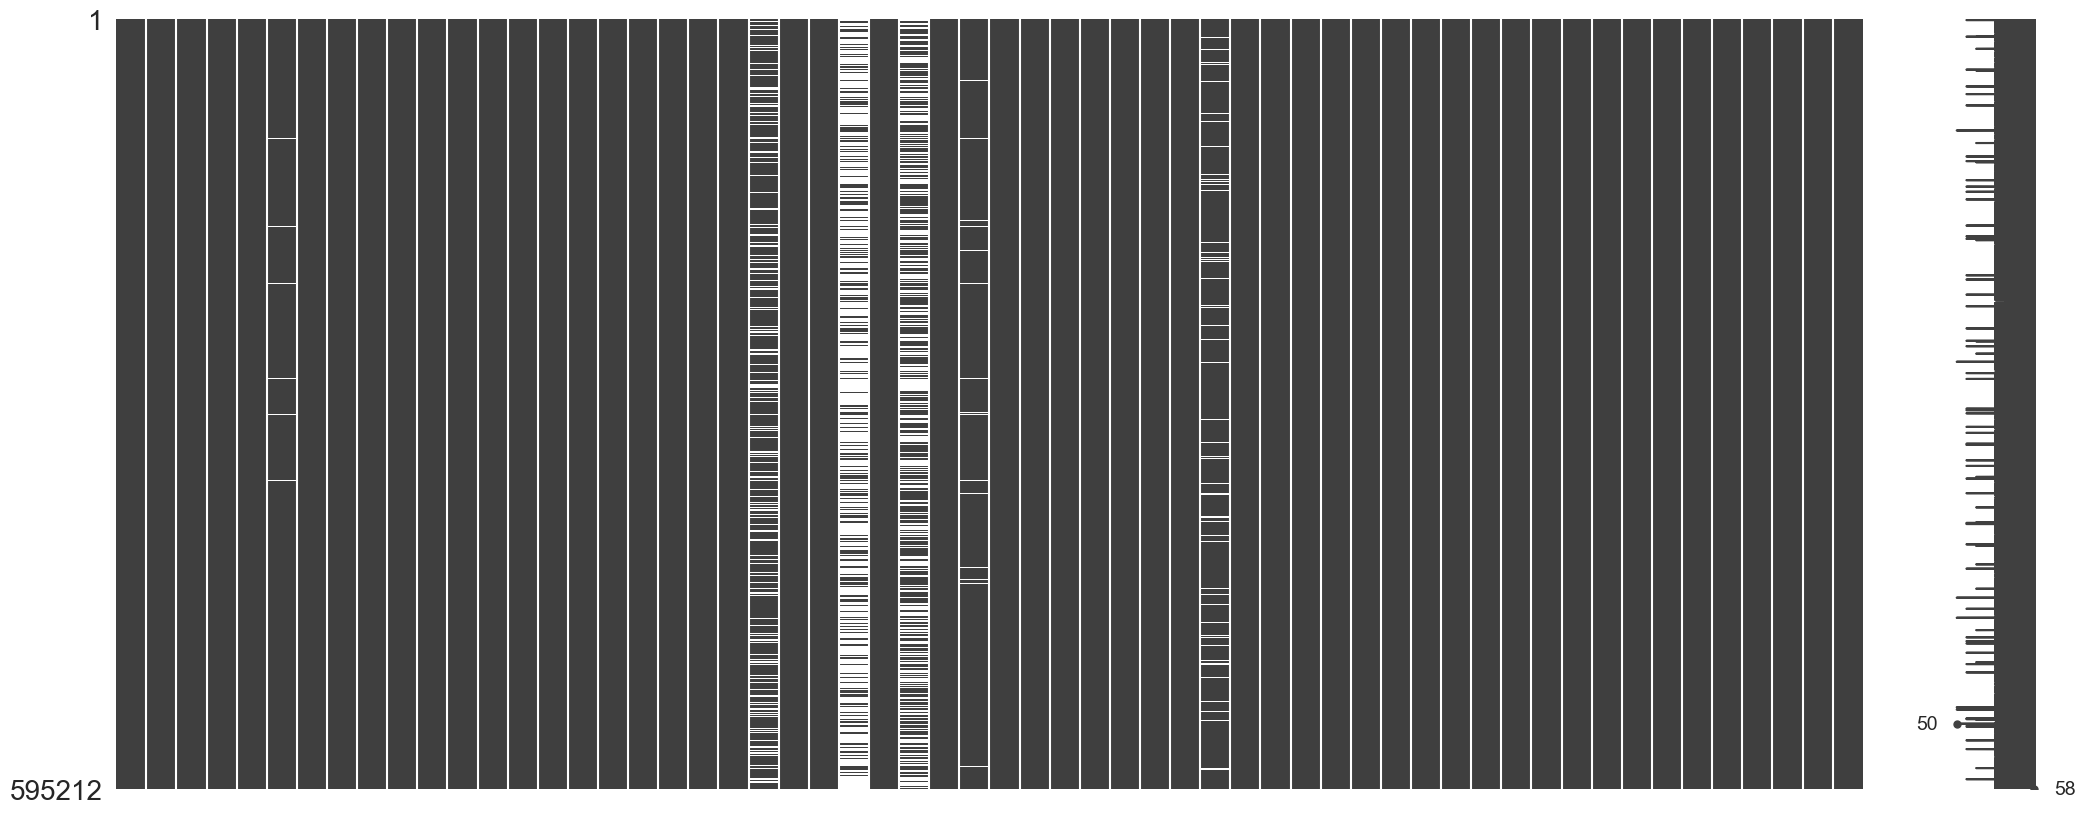

In [3]:
#데이터 설명에서 Nan = -1임을 공지
#na값 시각화 
import missingno as msno
train_copy = train.copy().replace(-1, np.nan)
msno.matrix(df=train_copy)

- 전체 58개 변수중 결측치가 없는 것은 50개(8개는 결측치 존재) *매트릭스 우하단 확인

---
#### 1. 변수요약

In [4]:
##변수 요약 함수, 제공된 데이터 설명을 참조하여 구성함 
def resumetable(df): 
    print('features shape: ', df.shape)
    summary = pd.DataFrame(df.dtypes, columns = ['type'])
    summary['NA'] = (df==-1).sum().values
    summary['Unique'] = df.nunique().values
    
    summary['Data Type'] = None
    for col in df.columns: 
        if 'bin' in col or col == 'target': 
            summary.loc[col, 'Data Type'] = 'binary'     #변수명에 bin이 포함되어 있거나 target이면 이진형 
        elif 'cat' in col: 
            summary.loc[col, 'Data Type'] = 'nominal'    #변수명에 cat이 포함되어 있으면 명목형 
        elif df[col].dtype == np.float64: 
            summary.loc[col, 'Data Type'] = 'continuos'  #변수타입이 float이면 연속형, int이면 순서형 
        elif df[col].dtype == np.int64: 
            summary.loc[col, 'Data Type'] = 'ordinary'
        
    return summary

In [5]:
summary = resumetable(train)
summary

features shape:  (595212, 58)


,type,NA,Unique,Data Type
target,int64,0,2,binary
ps_ind_01,int64,0,8,ordinary
ps_ind_02_cat,int64,216,5,nominal
ps_ind_03,int64,0,12,ordinary
ps_ind_04_cat,int64,83,3,nominal
ps_ind_05_cat,int64,5809,8,nominal
ps_ind_06_bin,int64,0,2,binary
ps_ind_07_bin,int64,0,2,binary
ps_ind_08_bin,int64,0,2,binary
ps_ind_09_bin,int64,0,2,binary


In [6]:
#작성한 summary함수를 사용하여, 타입별 변수리스트를 쉽게 만들 수 있다. 
print(summary[summary['Data Type']=='binary'].index)
print(summary[summary['Data Type']=='nominal'].index)
print(summary[summary['Data Type']=='continuos'].index)
print(summary[summary['Data Type']=='ordinary'].index)

print('------------------------------------------------------------------')

print(summary[summary['type']=='int64'].index)
print(summary[summary['type']=='float64'].index)

Index(['target', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],
      dtype='object')
Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')
Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object')
Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_car_11',
       'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
       'ps_calc_09', 'ps_calc

---
#### 2. 시각화

In [7]:
#count plot에 %를 표시하기 위함 함수 제작 
def write_percent(ax, total_size): 
    for patch in ax.patches: 
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()  #도형 좌측 테두리의 x축 위치 
        percent = height / total_size*100 

        ax.text(x=left_coord + width/2.0,    #x축 위치
                y=height + total_size*0.001, #y축 위치
                s=f'{percent:1.1f}%',       #입력값
                ha='center')                #가운데 정렬

Text(0.5, 1.0, 'Target Distribution')

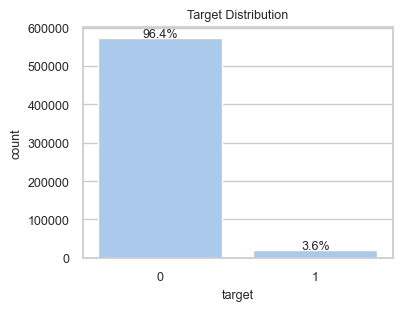

In [8]:
#시각화 1 : target 분포 확인
plt.figure(figsize=(4,3))
ax=sns.countplot(data=train, x='target')
write_percent(ax, len(train))
ax.set_title('Target Distribution')

- 실제 보험금을 청구한 고객수는 전체의 3.6%에 불과 

In [9]:
## 변수별 target=1인 비율을 확인하기 위한 함수 
import matplotlib.gridspec as gridspec 

def plot_target_ratio_by_features(df, features, num_rows, num_cols, size=(9,18)): 
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(num_rows, num_cols)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for idx, feature in enumerate(features): 
        ax=plt.subplot(grid[idx])
        sns.barplot(data=df, x=feature, y='target', ax=ax)

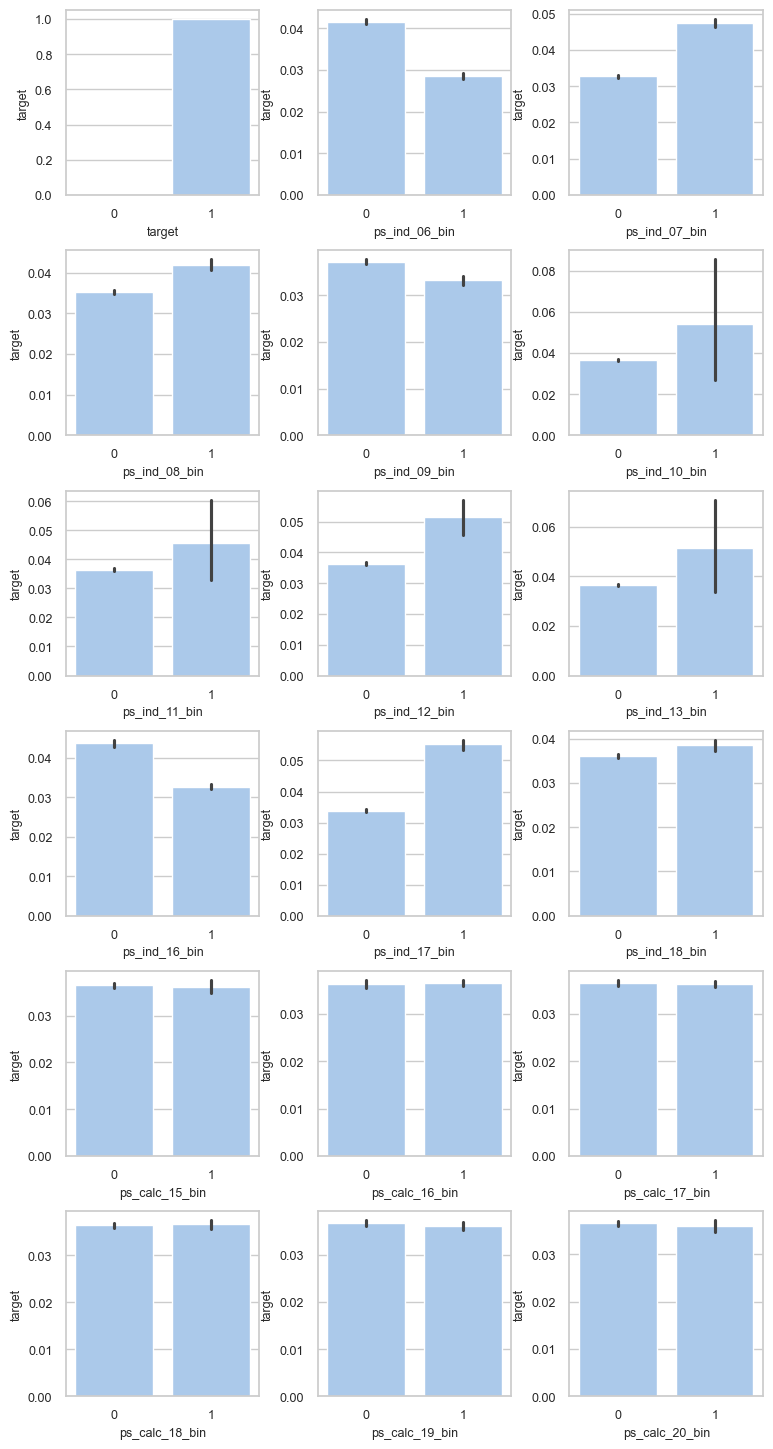

In [10]:
#시각화 2: binary features (18개)
bin_features = summary[summary['Data Type']=='binary'].index
plot_target_ratio_by_features(train, bin_features, 6, 3)

- ps_ind_10_bin ~ ps_ind_13_bin은 신뢰구간이 너무 커서 사용하기 어렵다. 
- ps_calc_*_* 변수는 target값의 비중에 차이가 없어 변수로써 변별력이 없다. 

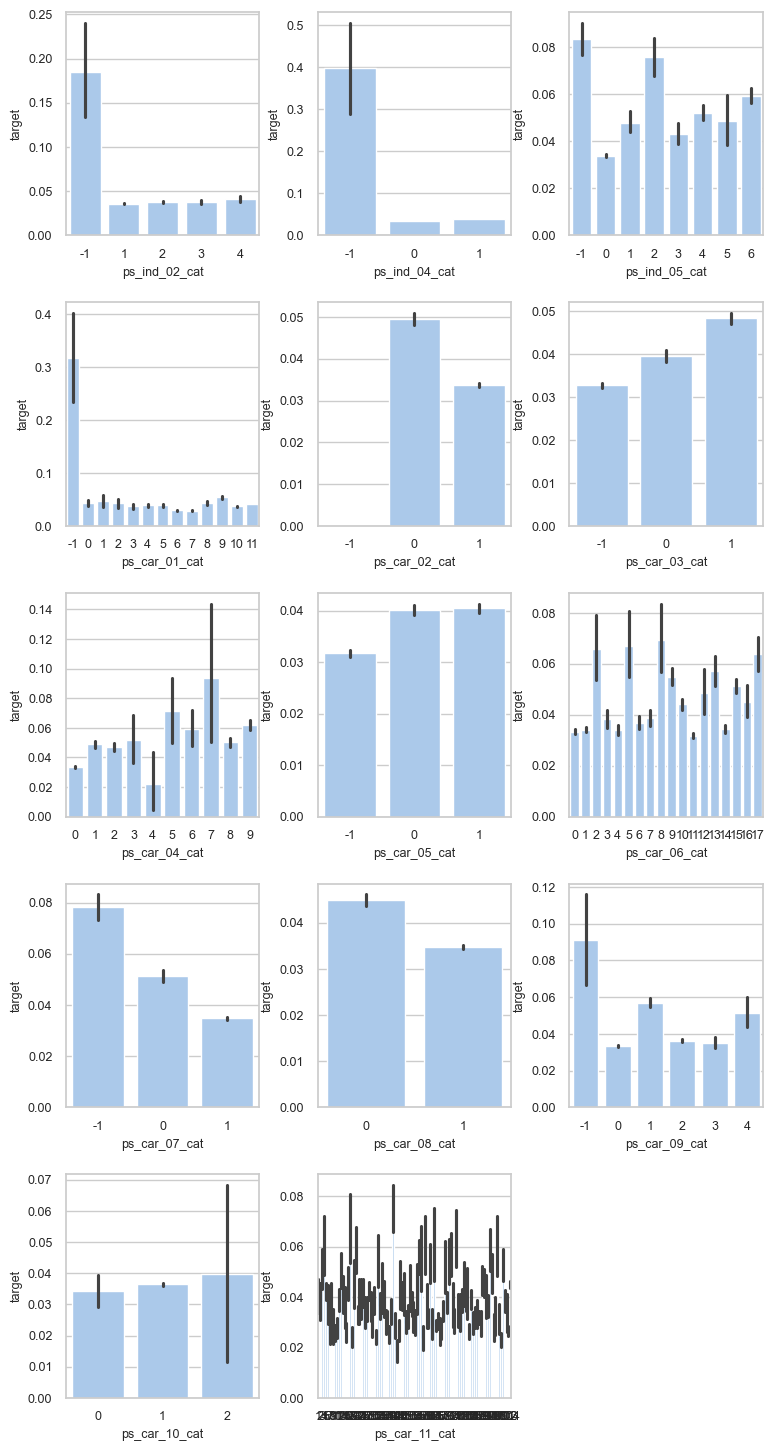

In [11]:
#시각화 3: nominal features (14개)
nom_features = summary[summary['Data Type']=='nominal'].index
plot_target_ratio_by_features(train, nom_features, 5, 3)

- 결측값 -1인 경우에 target값 구성비가 큰 차이를 보이는 경우가 많음 --> 결측값을 포함한 데이터를 제거하는 것은 바람직하지 않음 

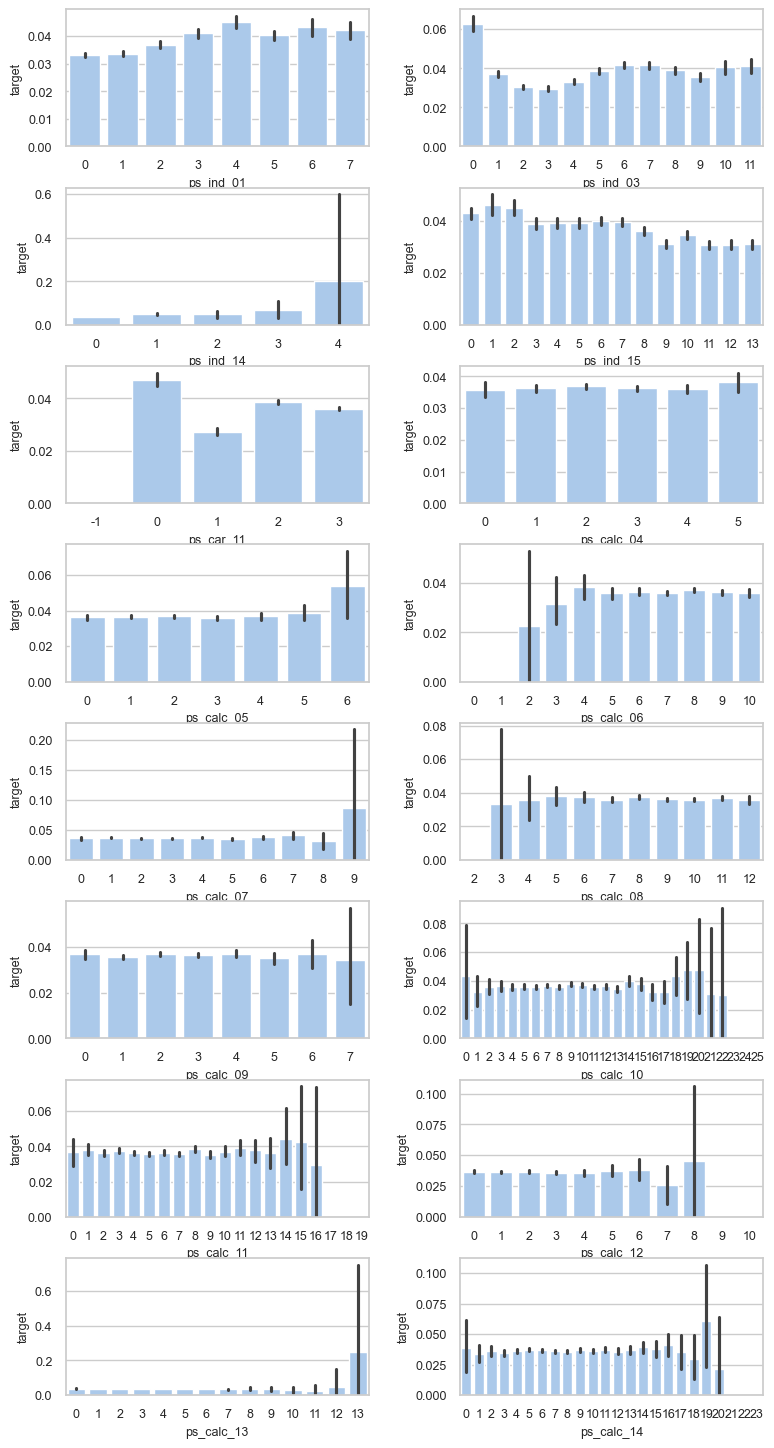

In [12]:
#시각화 4 : ordinary features (16개)
ord_features = summary[summary['Data Type']=='ordinary'].index
plot_target_ratio_by_features(train, ord_features, 8, 2)

- ps_ind_14와 ps_calc_04~14는 항목별 target값 비중이 비슷하고, 일부 차이가 있더라도 신뢰구간이 매우 크다 --> 삭제 대상  

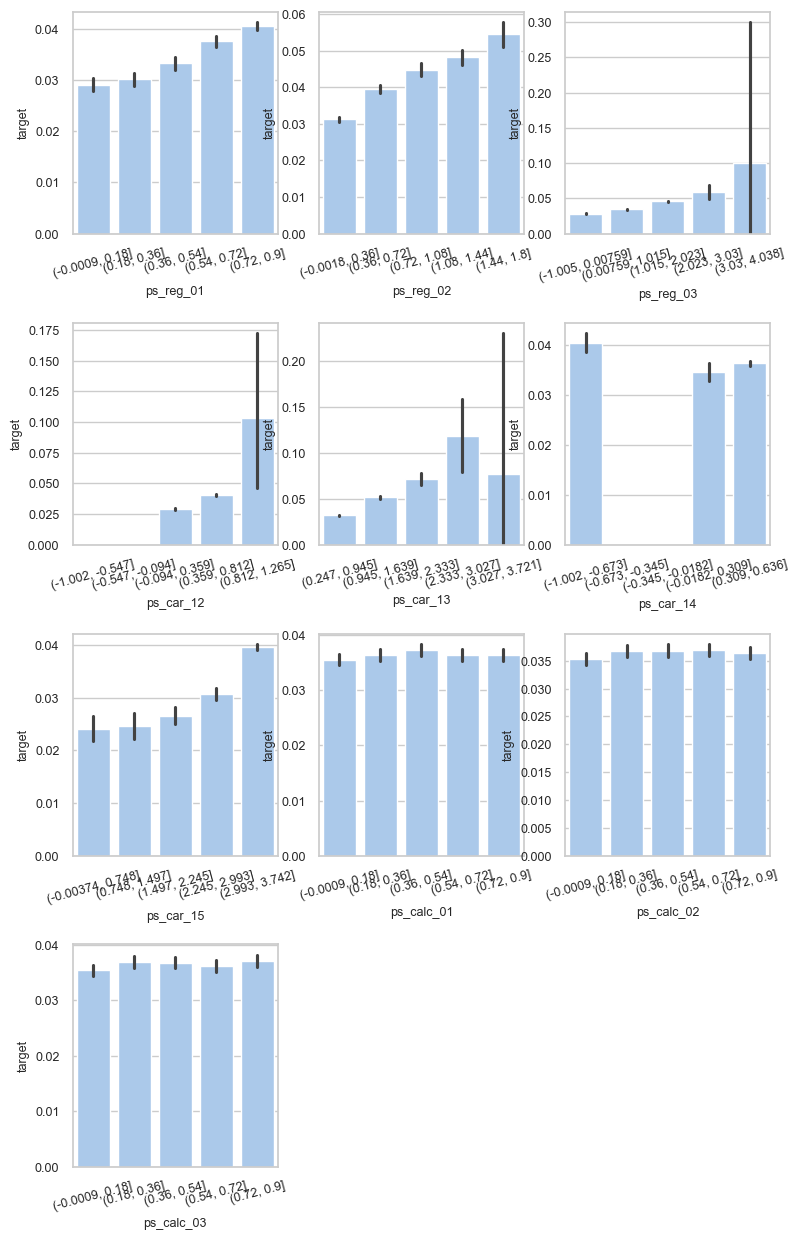

In [13]:
#시각화 5 : continuous features (10개)
#연속형이므로 pd.cut()을 활용, 5개의 구간으로 나눈다. 
con_features = summary[summary['Data Type']=='continuos'].index
grid = gridspec.GridSpec(4,3)
plt.figure(figsize=(9,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for idx, con_feature in enumerate(con_features): 
    train[con_feature] = pd.cut(train[con_feature], 5)
    
    ax = plt.subplot(grid[idx])  # fig에 서브플롯 추가
    sns.barplot(data=train, x=con_feature, y='target', ax=ax)
    ax.tick_params(axis='x', labelrotation = 15)   #x축 레이블 회전 

- ps_calc_* 변수들은 변별력이 없으므로 제거대상 

<Axes: >

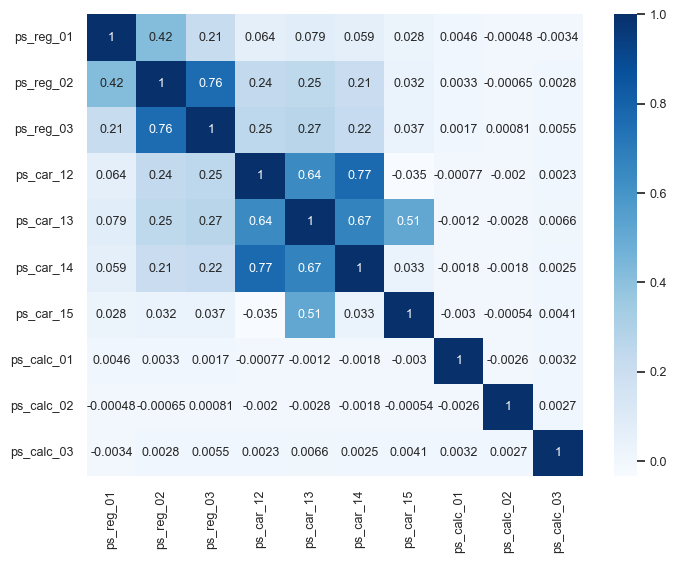

In [20]:
#continuous features들간 상관관계 --> 먼저 na값 제거해야 한다. 
train_temp = train.copy().replace(-1, np.nan)
train_temp = train_temp.dropna()
con_features2 = summary[summary['Data Type']=='continuos'].index

plt.figure(figsize=(8,6))
con_corr = train_copy[con_features2].corr()
sns.heatmap(con_corr, annot=True, cmap='Blues')

- 상관관계가 높은 ps_reg_02와 ps_reg_03, ps_car_12와 ps_car_14중 하나의 변수 제거 검토  
  > 실전에서 변수들을 제거한 경우와 그렇지 않은 경우의 모델성능을 비교해가며 결정 